In [2]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload
from functools import partial

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import (OperatorModel, OperatorPDEModel,CholInducedRKHS,
                            CholOperatorModel)
import plotting
reload(plotting)
from plotting import (plot_obs,plot_compare_error,
                      plot_input_data,plot_compare_error,
                      plot_obs_parabolic, plot_init_final_parabolic)

from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs, # changed - could live in parabolic_data_utils ?
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel,
    fit_kernel_params,log1pexp,
    inv_log1pexp,get_anisotropic_gaussianRBF
)

In [3]:
# Sample m training functions from a GP
m = 3
kernel_GP = get_gaussianRBF(0.2)
xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
u0_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = m,
                                        X = xy_pts, 
                                        smooth= 2,
                                        kernel = kernel_GP,
                                        reg = 1e-8,
                                        seed = 2024
                                    )
                          )

vec_u0_true_functions = tuple([np.vectorize(u) for u in u0_true_functions])
vmapped_u0_true_functions = tuple([jax.vmap(u) for u in u0_true_functions])
# Solve m Burgers' equations with IC's: u0_true_functions 
# kappa = 0.001
# alpha = 5.
kappa = 0.01
alpha = 1.

u_true_functions = []
ut_true_functions = []
interpolants = []
t_vals_s = []
sols_s = []

for u0_true_function in vec_u0_true_functions:
  res = list(build_burgers_data(func_u0=u0_true_function,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999))
  u_true_functions.append(res[0])
  ut_true_functions.append(res[1])
  interpolants.append(res[2])
  t_vals_s.append(res[3])
  sols_s.append(res[4])

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

In [4]:
# Ghost Chebyshev grids
# num_grid_x = 31
# num_grid_t = 26
num_grid_x = 7
num_grid_t = 6

tx_ints , tx_bdys = [], []
for _ in range(m):
    res = build_tx_grid_chebyshev([0,1],[0,1],
                            num_grid_t,
                            num_grid_x,
                            alpha = 0.5)
    tx_ints.append(res[0])
    tx_bdys.append(res[1])

tx_ints = tuple(tx_ints)
tx_bdys = tuple(tx_bdys)
# Tuple of ghost grids
tx_all = tuple(jnp.vstack([tx_int,tx_bdy]) for tx_int,tx_bdy in zip(tx_ints,tx_bdys))

In [5]:
# List of number of observation points per u
num_obs = [20]*m

# Get (X^m, u^m(X^m))
tx_obs = []
u_obs = []
for i, (tx_int,tx_bdy) in enumerate(zip(tx_ints,tx_bdys)):
    _,tx_ob = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs[i],
        jax.random.PRNGKey(i),
        times_to_observe = (0,)
            )
    tx_obs.append(tx_ob)

u_obs = tuple(u(tx_ob) for tx_ob,u in zip(tx_obs,u_true_functions))

In [6]:
# Define grid to plot
num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

In [7]:
# Plot u's
# plot_obs_parabolic(tx_fine, tx_all, tx_obs, u_true_functions, title = 'True u_s')

In [8]:
# Plot initial and final conditions
num_fine_grid = 500
grid_points = jnp.linspace(0,1,num_fine_grid)
# plot_init_final_parabolic(grid_points, u_true_functions, title = 'Initial and final conditions')

In [9]:
# Features of u and P
u_operators = (eval_k,) # This enforces 1_5 step method
feature_operators = (eval_k,dx_k,dxx_k)


# Fit parameters of kernel for u
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params_s = []
ml_value_s = []
k_u_s = []
for i in range(m):
    res = fit_kernel_params(param_ani_gaussian_RBF,tx_obs[i],u_obs[i],jnp.zeros(2))
    ML_lengthscales = log1pexp(res[0])
    k_u_s.append(get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(res[0]))))
    print(1/(jnp.sqrt(ML_lengthscales)))

u_models = tuple([CholInducedRKHS(
    tx_all[i],
    u_operators,
    k_u_s[i]
    ) for i in range(m)])

[0.83955206 0.09126054]
[1.07074177 0.21582955]
[1.1540885  0.12721168]


In [10]:
# Get necessary tuples
observation_points = tuple(tx_obs)
observation_values = tuple(u_obs)
collocation_points = tx_ints

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val)
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(
    model.evaluate_operators(feature_operators,tx_int,model_params)).reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        ) for tx_int,model,model_params in zip(tx_ints,u_models,all_u_params_init)])

In [11]:
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_u_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)

In [12]:
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 5.,
    )

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.004674, Jres = 7.92, alpha = 0.08333, improvement_ratio = 1.01
Iteration 1, loss = 0.003466, Jres = 0.6165, alpha = 0.06944, improvement_ratio = 0.9848
Iteration 2, loss = 0.00291, Jres = 0.5811, alpha = 0.05787, improvement_ratio = 1.019
Iteration 3, loss = 0.002552, Jres = 0.2625, alpha = 0.04823, improvement_ratio = 1.006
Iteration 4, loss = 0.002274, Jres = 0.1889, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.002048, Jres = 0.1319, alpha = 0.03349, improvement_ratio = 0.9995
Iteration 100, loss = 0.000454, Jres = 3.475e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 0.0004534, Jres = 9.054e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 0.000453, Jres = 7.53e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.0004528, Jres = 6.373e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 0.0004527, Jres = 5.42e-07, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.00045266604755465705
Converged


/tmp/ipykernel_3410791/3222514599.py:17: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


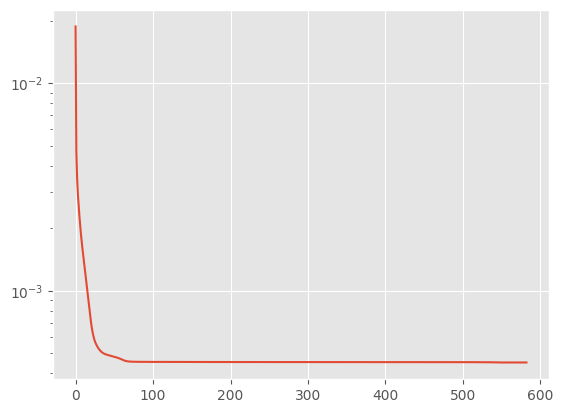

In [13]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(tx_ints[0]))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

How well do we satisfy the PDE at the ghost points ?

In [14]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))

Pre Refinement PDE MSE 0.000163741640574114
Post Refinement PDE MSE 0.00016240241529751488


In [15]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)

u_sols = EqnModel.get_u_params(params)
P_sol = EqnModel.get_P_params(params)

### Measures of accuracy for u's

Results for u_1


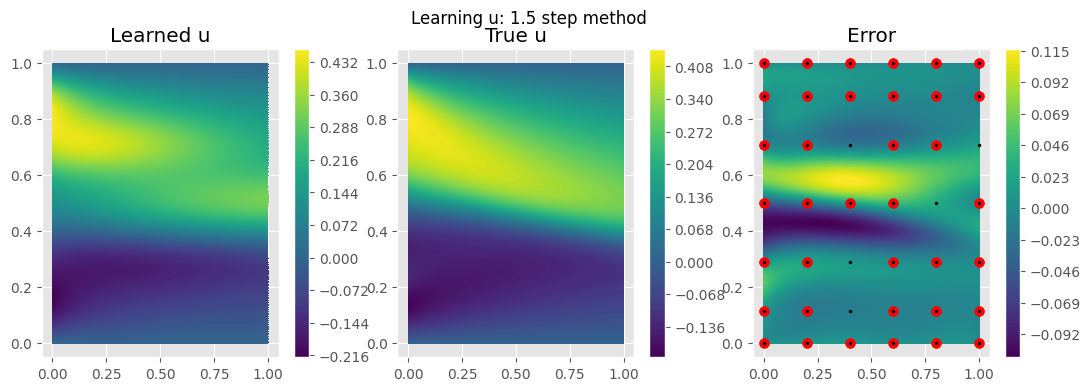

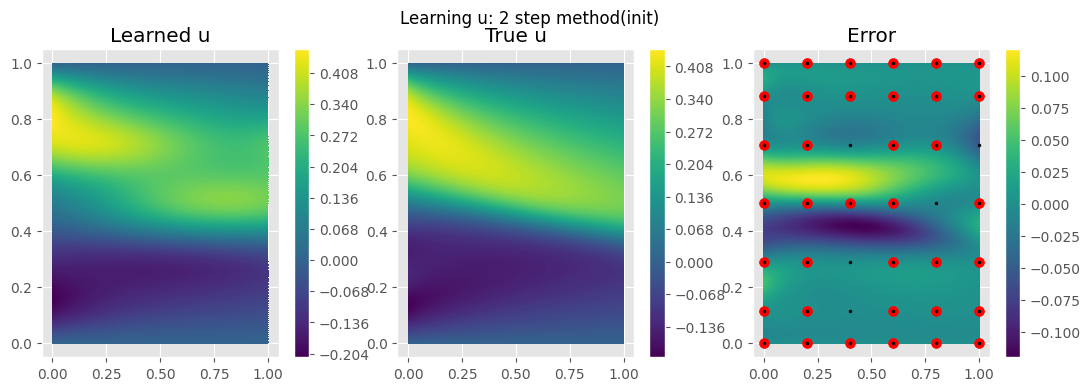

Results for u_2


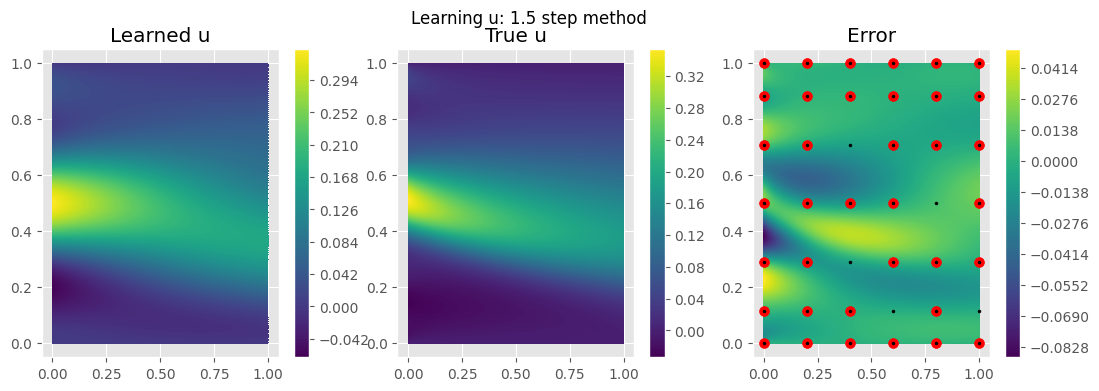

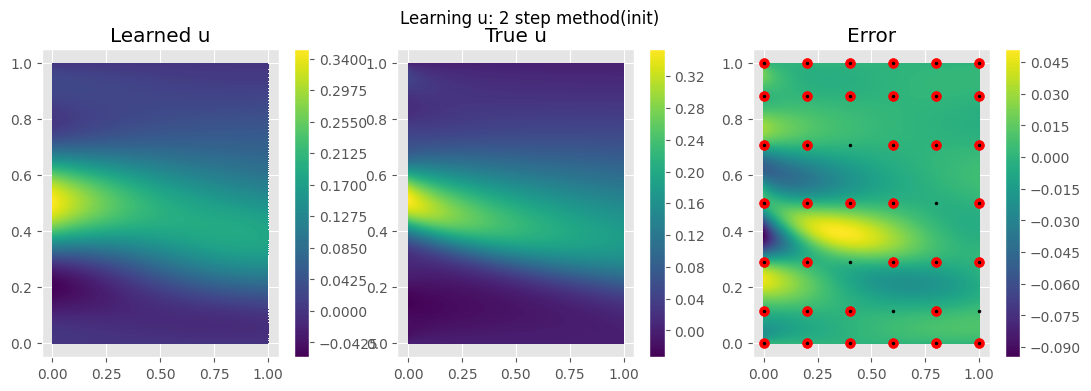

Results for u_3


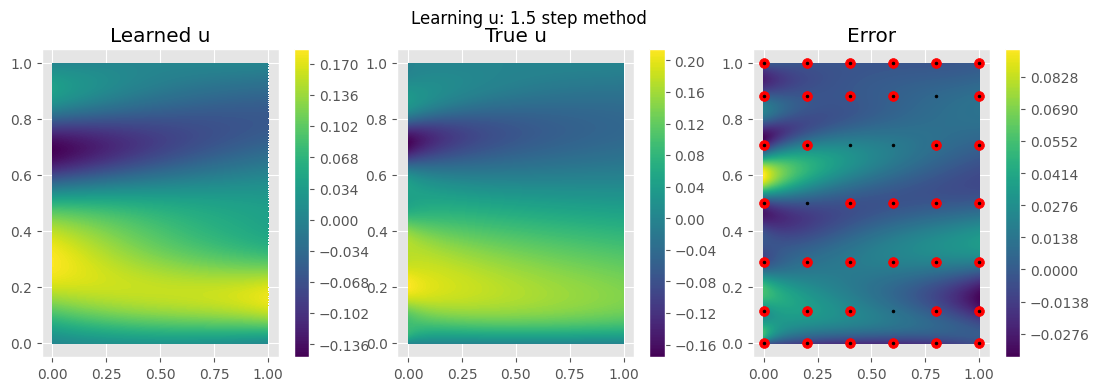

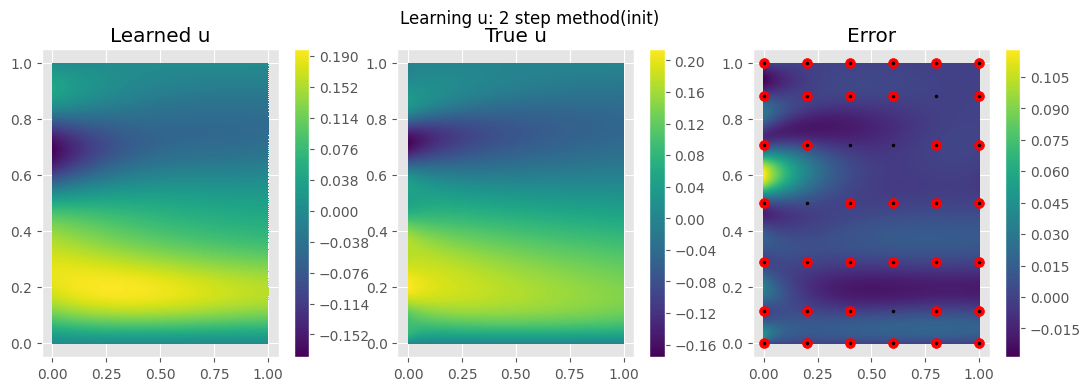

In [16]:
# Compare u's
# for i in range(len(u_true_functions)):
for i in range(3):
    print(f"Results for u_{i+1}")
    # Plot 
    plot_compare_error(tx_fine,
                       tx_all[i],
                       tx_obs[i],
                    lambda x:u_models[i].point_evaluate(x,u_sols[i]),
                    u_true_functions[i]
                    , title = 'Learning u: 1.5 step method')
    plot_compare_error(tx_fine,
                       tx_all[i],
                       tx_obs[i],
                    lambda x:u_models[i].point_evaluate(x,all_u_params_init[i]),
                    u_true_functions[i]
                    , title = 'Learning u: 2 step method(init)')

In [17]:
table_u_errors(
    tx_fine, u_models, u_sols, 
    u_true_functions, 
    all_u_params_init)

,1 step,2 step (at initialization)
0,18.045901,18.448579
1,13.680169,13.351465
2,18.731617,14.618258


### Measures of accuracy for P

#### Operator learning error

In [18]:
# Sample m u0 new functions from a GP
M = 15
kernel_GP = get_gaussianRBF(0.2)
xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
u0_new_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = M,
                                        X = xy_pts, 
                                        smooth= 2,
                                        kernel = kernel_GP,
                                        reg = 1e-8,
                                        seed = 2025
                                    )
                          )

vec_u0_new_true_functions = tuple([np.vectorize(u) for u in u0_new_true_functions])
vmapped_u0_new_true_functions = tuple([jax.vmap(u) for u in u0_new_true_functions])
# Solve m Burgers' equations with IC's: u0_true_functions 
# kappa = 0.001
# alpha = 5.
kappa = 0.01
alpha = 1.

u_new_true_functions = []
ut_new_true_functions = []
interpolants_new = []
t_vals_s_new = []
sols_s_new = []

for u0_new_true_function in vec_u0_new_true_functions:
  res = list(build_burgers_data(func_u0=u0_new_true_function,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999))
  u_new_true_functions.append(res[0])
  ut_new_true_functions.append(res[1])
  interpolants_new.append(res[2])
  t_vals_s_new.append(res[3])
  sols_s_new.append(res[4])

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

Collocation points for learning u

In [32]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

tx_all,_ = setup_problem_data(
    tx_int,
    tx_bdy,
    60,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)

In [ ]:
new_u_eval_fines = []
for i in range(M):
    model_grid_features = EqnModel.get_stacked_eqn_features(u_sols)
    @jit
    def get_pred_ut(input_features):
        return P_model.kernel_function(input_features,model_grid_features)@P_sol

    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

    new_obs = u_new_true_functions[i](tx_init_bdy)    

    tx_all_ = tx_all[0]

    # Object to capture learned solution : Fixing the first ?
    u_model = CholInducedRKHS(tx_all,
                                feature_operators,
                                k_u_s[0]
                                )

    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        

    # OPTIMIZE
    new_u_init = jnp.zeros(tx_all.shape[0]*len(feature_operators))

    u_params_pde,pde_convergence_data = LevenbergMarquadtMinimize(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        max_iter = 101,
        init_alpha=0.05,
        line_search_increase_ratio=1.4,
        print_every = 10
    )
    u_pde_adj,pde_refine_conv_data = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

    new_u_eval_fines.append(u_model.point_evaluate(tx_fine,u_pde_adj))

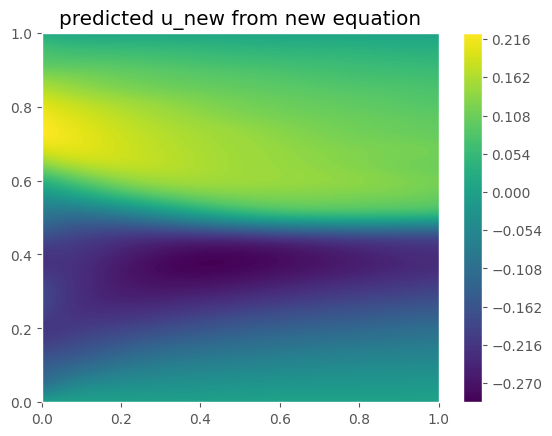

In [52]:
i = 3
plt.tricontourf(*tx_fine.T,new_u_eval_fines[i],200)
plt.title('predicted u_new from new equation')
plt.colorbar()

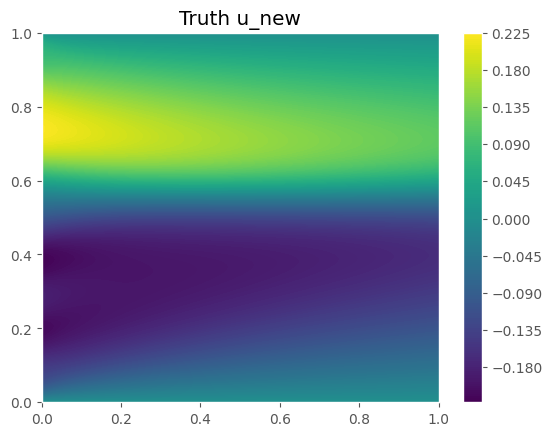

In [53]:
plt.tricontourf(*tx_fine.T,u_new_true_functions[i](tx_fine),200)
plt.title('Truth u_new')
plt.colorbar()

In [49]:
# True
new_u_true_eval_fines = [u(tx_fine) for u in u_new_true_functions]
# Pred
new_u_eval_fines = new_u_eval_fines

operator_learning_error = jnp.mean(jnp.array([get_nrmse(t,p) for t, p in zip(new_u_eval_fines,new_u_true_eval_fines)]))

In [55]:
print('Operator learning error 1.5 step:', operator_learning_error)

Operator learning error 1.5 step: 0.42195183495480837


In [58]:
new_u_eval_fines_2step = []
for i in range(M):
    model_grid_features = EqnModel.get_stacked_eqn_features(u_sols)

    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

    new_obs = u_new_true_functions[i](tx_init_bdy)    

    tx_all_ = tx_all[0]

    # Object to capture learned solution : Fixing the first ?
    u_model = CholInducedRKHS(tx_all,
                                feature_operators,
                                k_u_s[0]
                                )

    @jit
    def get_pred_ut_2step(input_features):
        init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
        return P_model.predict_new(input_features,init_P_features,P_params_naive)
    

    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut_2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        

    # OPTIMIZE
    new_u_init = jnp.zeros(tx_all.shape[0]*len(feature_operators))

    u_params_pde,pde_convergence_data = LevenbergMarquadtMinimize(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        max_iter = 101,
        init_alpha=0.05,
        line_search_increase_ratio=1.4,
        print_every = 10
    )
    u_pde_adj,pde_refine_conv_data = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

    new_u_eval_fines_2step.append(u_model.point_evaluate(tx_fine,u_pde_adj))

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 5.127e-06, Jres = 181.9, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 2.647e-06, Jres = 3.451e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 2.072e-06, Jres = 4.836e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.708e-06, Jres = 2.886e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.42e-06, Jres = 2.154e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.179e-06, Jres = 1.733e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 4.867e-07, Jres = 7.086e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 1.784e-07, Jres = 1.48e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 7.007e-08, Jres = 5.241e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.3e-08, Jres = 1.136e-08, alpha = 2.835e-05, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.410443778943872e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 2.361e-06, Jres = 32.13, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 1.643e-06, Jres = 3.165e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.33e-06, Jres = 2.534e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.187e-06, Jres = 1.755e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.109e-06, Jres = 1.266e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.056e-06, Jres = 9.581e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 8.667e-07, Jres = 4.501e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 3.913e-07, Jres = 2.215e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.555e-07, Jres = 5.664e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 1.225e-07, Jres = 1.697e-08, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 7.518e-08, Jres = 1.225e-08, alpha = 4.579e-06, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 8.492167352019175e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 4.478e-06, Jres = 71.11, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 2.207e-06, Jres = 1.946e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.429e-06, Jres = 4.921e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.08e-06, Jres = 2.972e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 9.033e-07, Jres = 2.037e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.94e-07, Jres = 1.49e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 5.073e-07, Jres = 5.793e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 1.897e-07, Jres = 1.99e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.522e-08, Jres = 4.482e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.302e-08, Jres = 1.201e-08, alpha = 2.835e-05, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 7.602072813773573e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 3.186e-06, Jres = 61.41, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 1.986e-06, Jres = 9.985e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.693e-06, Jres = 2.73e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.459e-06, Jres = 1.66e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.248e-06, Jres = 1.327e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.061e-06, Jres = 1.131e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 5.409e-07, Jres = 4.605e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 2.784e-07, Jres = 1.173e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.237e-07, Jres = 4.681e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 7.771e-08, Jres = 1.211e-08, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 5.064e-08, Jres = 1.1e-08, alpha = 4.579e-06, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 9.229868218747251e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.779e-06, Jres = 81.61, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 9.293e-07, Jres = 1.611e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 6.988e-07, Jres = 2.958e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 5.578e-07, Jres = 1.814e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 4.512e-07, Jres = 1.343e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 3.635e-07, Jres = 1.068e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 1.214e-07, Jres = 4.345e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.485e-08, Jres = 9.517e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.334e-08, Jres = 3.344e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.0109124892196905e-09
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.819e-06, Jres = 82.92, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 1.145e-06, Jres = 6.96e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 8.772e-07, Jres = 2.812e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 7.392e-07, Jres = 1.814e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 6.539e-07, Jres = 1.308e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 5.907e-07, Jres = 1.002e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 4.078e-07, Jres = 4.257e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 1.925e-07, Jres = 1.617e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 7.476e-08, Jres = 4.765e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.151e-08, Jres = 1.17e-08, alpha = 2.835e-05, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 9.559000123821417e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 2.211e-06, Jres = 92.47, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 1.395e-06, Jres = 9.321e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.136e-06, Jres = 2.642e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 9.344e-07, Jres = 1.652e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.587e-07, Jres = 1.28e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 6.07e-07, Jres = 1.058e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 2.207e-07, Jres = 4.049e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 1.412e-07, Jres = 7.875e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.53e-08, Jres = 4.591e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.732494068140492e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 5.984e-07, Jres = 41.29, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 3.592e-07, Jres = 7.908e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 2.753e-07, Jres = 1.709e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 2.264e-07, Jres = 1.092e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.918e-07, Jres = 8.073e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.644e-07, Jres = 6.357e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 8.832e-08, Jres = 2.666e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.598e-08, Jres = 7.951e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.737e-08, Jres = 2.86e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 1.8236230065021878e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 5.834e-07, Jres = 43.12, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 3.751e-07, Jres = 3.433e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 3.105e-07, Jres = 1.309e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 2.598e-07, Jres = 8.584e-07, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 2.157e-07, Jres = 6.819e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.772e-07, Jres = 5.747e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 7.473e-08, Jres = 2.518e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.494e-08, Jres = 6.182e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.803e-08, Jres = 2.822e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 1.5728436264148165e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 4.18e-06, Jres = 192.6, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 2.403e-06, Jres = 2.09e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.756e-06, Jres = 3.88e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.46e-06, Jres = 2.392e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.295e-06, Jres = 1.647e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.181e-06, Jres = 1.209e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 8.555e-07, Jres = 4.86e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 3.363e-07, Jres = 2.138e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.039e-07, Jres = 5.088e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 7.688e-08, Jres = 1.325e-08, alpha = 2.835e-05, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 1.0188806872817805e-07
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 4.828e-07, Jres = 101.9, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 3.337e-07, Jres = 1.299e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 2.805e-07, Jres = 9.019e-07, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 2.402e-07, Jres = 5.118e-07, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 2.067e-07, Jres = 4.001e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.79e-07, Jres = 3.428e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 1.111e-07, Jres = 1.573e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.203e-08, Jres = 6.018e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 2.952e-08, Jres = 2.97e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.8610136269678886e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 4.675e-07, Jres = 54.29, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 2.514e-07, Jres = 4.935e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.751e-07, Jres = 6.08e-07, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.347e-07, Jres = 3.85e-07, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.094e-07, Jres = 2.534e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 9.157e-08, Jres = 1.946e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 5.082e-08, Jres = 9.649e-08, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 2.451e-08, Jres = 4.186e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.143e-09, Jres = 1.435e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.6611619964106826e-09
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.374e-06, Jres = 108.1, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 6.147e-07, Jres = 1.885e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 4.816e-07, Jres = 2.245e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 4.039e-07, Jres = 1.27e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 3.416e-07, Jres = 9.507e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.881e-07, Jres = 7.796e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 1.252e-07, Jres = 3.37e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 3.017e-08, Jres = 7.303e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 9.416e-09, Jres = 1.577e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 1.5517090093422005e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.259e-06, Jres = 112.9, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 5.903e-07, Jres = 1.842e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 3.728e-07, Jres = 2.177e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 2.692e-07, Jres = 1.183e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 2.156e-07, Jres = 7.421e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.852e-07, Jres = 4.981e-07, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 1.274e-07, Jres = 1.817e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.295e-08, Jres = 6.748e-08, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.252e-08, Jres = 2.652e-08, alpha = 0.0001755, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.799181570866346e-08
Converged


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 3.297e-06, Jres = 26.86, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 2.125e-06, Jres = 1e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 1.664e-06, Jres = 3.79e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.401e-06, Jres = 2.475e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 1.221e-06, Jres = 1.824e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 1.079e-06, Jres = 1.428e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.744e-07, Jres = 6.106e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 3.183e-07, Jres = 2.104e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 1.206e-07, Jres = 6.443e-08, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 7.85e-08, Jres = 1.624e-08, alpha = 2.835e-05, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 1.0516444412235974e-07
Converged


In [59]:
# True
new_u_true_eval_fines = [u(tx_fine) for u in u_new_true_functions]
# Pred
new_u_eval_fines2step = new_u_eval_fines_2step

operator_learning_error_2step = jnp.mean(jnp.array([get_nrmse(t,p) for t, p in zip(new_u_eval_fines_2step,new_u_true_eval_fines)]))

In [60]:
print('Operator learning error 2 step:', operator_learning_error_2step)

Operator learning error 2 step: 0.3624642872243762
